<a href="https://colab.research.google.com/github/MayerT1/Forest_Structure_Function_Module/blob/main/Meta_model_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Meta Model approach

https://dataaspirant.com/stacking-technique/

https://www.youtube.com/watch?v=0BGLfYY26zQ

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

https://github.com/dataprofessor/python/blob/main/Stacking_Classifier.ipynb

In [91]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.8 MB/s eta 0:00:00


In [92]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn import tree
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import StackingRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from subprocess import check_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/sample_partition
!ls

/content/drive/MyDrive/sample_partition
op_rf.csv  rf_individualtree.png  temp_file.pdf  training.csv
out.csv    temp_file		  testing.csv	 validation.csv


In [ ]:
train=pd.read_csv("training.csv")
print("Train dataset has {} samples and {} attributes".format(*train.shape))


train_copy = train.copy()
train_copy

In [ ]:
test=pd.read_csv("testing.csv")
print("Test dataset has {} samples and {} attributes".format(*test.shape))

print("rh100 height distribution of Testing Data set")
sns.histplot(test,x="rh100")

test["rh100"].describe()

test_copy = test.copy()


In [ ]:
validation=pd.read_csv("validation.csv")
print("validation dataset has {} samples and {} attributes".format(*validation.shape))

print("rh100 height distribution of validation Data set")
sns.histplot(validation,x="rh100")

validation["rh100"].describe()

validation_copy = validation.copy()
validation_copy

# Data handeling

train

In [ ]:
y_train=pd.DataFrame(train_copy['rh100'])
y_train

In [ ]:
train_copy.drop(['system:index', 'class', 'rh100', 'rh100_1', 'random', '.geo'], axis=1, inplace=True)
x_train = train_copy
x_train

test

In [ ]:
y_test=pd.DataFrame(test_copy['rh100'])
y_test

In [ ]:
test_copy.drop(['system:index', 'class', 'rh100', 'rh100_1', 'random', '.geo'], axis=1, inplace=True)
x_test = test_copy
x_test

In [ ]:
y_validation = pd.DataFrame(validation_copy['rh100'])
y_validation

In [ ]:
validation_copy.drop(['system:index', 'class', 'rh100', 'rh100_1', 'random', '.geo'], axis=1, inplace=True)
x_validation = validation_copy
x_validation

# Grid Search params

In [11]:
###scale data for algorithms that need it
sc = StandardScaler()
x_train_sc = pd.DataFrame(sc.fit_transform(x_train))
x_test_sc = pd.DataFrame(sc.transform(x_test))

In [12]:
folds  = 5
score_calc = 'neg_mean_squared_error'

## Linear Regression

In [13]:
def get_best_score(grid):

    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)

    return best_score

In [110]:
lr  = LinearRegression()
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(lr , parameters, cv = folds, verbose = 1 , scoring = score_calc)
grid_linear.fit(x_train.values, y_train['rh100'].values)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
6.755765128257325
{'copy_X': True, 'fit_intercept': False}
LinearRegression(fit_intercept=False)


In [111]:
lr = LinearRegression()
lr.fit(x_train.values, y_train['rh100'].values)
pred_linreg_all = lr.predict(x_test.values)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [112]:
# # Rsquared Score for Linear Regression
# r2_score(y_test, pred_linreg_all)

print("MAE train on test",mean_absolute_error(y_test,pred_linreg_all))
print("MSE train on test",mean_squared_error(y_test,pred_linreg_all))
r2 = r2_score(y_test,pred_linreg_all)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_linreg_all))))

MAE train on test 4.913182824146672
MSE train on test 42.40235927538297
R2 train on test 0.49106534499516974
RMSE train on test 1.8736020019886082


## Scaled SDG

In [113]:
sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv = folds, verbose = 0, scoring = score_calc)
grid_sgd.fit(x_train_sc.values, y_train["rh100"].values)

sc_sgd = get_best_score(grid_sgd)
pred_sgd = grid_sgd.predict(x_test_sc.values)

6.762639769213382
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


In [114]:
print("MAE train on test",mean_absolute_error(y_test,pred_sgd))
print("MSE train on test",mean_squared_error(y_test,pred_sgd))
r2 = r2_score(y_test,pred_sgd)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_sgd))))

MAE train on test 4.935269874343007
MSE train on test 43.22028627960679
R2 train on test 0.48124816961088757
RMSE train on test 1.8831549874164948


## DT

In [115]:
param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30], 'random_state': [5] }

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(x_train.values, y_train['rh100'].values)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(x_test.values)

6.80518378228409
{'max_depth': 8, 'max_features': 12, 'max_leaf_nodes': 20, 'min_samples_split': 20, 'random_state': 5}
DecisionTreeRegressor(max_depth=8, max_features=12, max_leaf_nodes=20,
                      min_samples_split=20, random_state=5)


In [116]:
# r2_score(y_test, pred_dtree)

print("MAE train on test",mean_absolute_error(y_test,pred_dtree))
print("MSE train on test",mean_squared_error(y_test,pred_dtree))
r2 = r2_score(y_test,pred_dtree)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_dtree))))

MAE train on test 5.131581189885009
MSE train on test 50.117857556844925
R2 train on test 0.3984600154057413
RMSE train on test 1.9571886914210854


## RF

In [117]:
#{'min_samples_split': 3, 'n_estimators': 150, 'random_state': 5}
param_grid = {'min_samples_split' : [3], 'n_estimators' : [150], 'random_state': [5]}
#param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [50, 60, 70, 100, 150], 'random_state': [5]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 3, scoring = score_calc)
grid_rf.fit(x_train.values, y_train['rh100'].values)

sc_rf = get_best_score(grid_rf)
pred_rf = grid_rf.predict(x_test.values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-25.224 total time=  29.6s
[CV 2/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-26.678 total time=  29.6s
[CV 3/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-33.305 total time=  27.5s
[CV 4/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-37.898 total time=  20.7s
[CV 5/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-43.471 total time=  30.9s
5.7719469180314995
{'min_samples_split': 3, 'n_estimators': 150, 'random_state': 5}
RandomForestRegressor(min_samples_split=3, n_estimators=150, random_state=5)


In [118]:
print("MAE train on test",mean_absolute_error(y_test,pred_rf))
print("MSE train on test",mean_squared_error(y_test,pred_rf))
r2 = r2_score(y_test,pred_rf)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_rf))))

MAE train on test 4.931965801996023
MSE train on test 43.896556139547215
R2 train on test 0.4731312352293904
RMSE train on test 1.8909179345788139


## scaled KNN

In [119]:
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(x_train_sc.values, y_train['rh100'].values)
sc_knn = get_best_score(grid_knn)
pred_knn = grid_knn.predict(x_test_sc.values)

5.990942177850225
{'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')


In [120]:
print("MAE train on test",mean_absolute_error(y_test,pred_knn))
print("MSE train on test",mean_squared_error(y_test,pred_knn))
r2 = r2_score(y_test,pred_knn)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_knn))))

MAE train on test 5.590596634763137
MSE train on test 58.230406923911175
R2 train on test 0.30108907699820553
RMSE train on test 2.0322038370211084


## XGBoost

In [121]:
#{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'random_state': 5}

param_grid = {'learning_rate' : [0.01], 'n_estimators' : [200], 'random_state': [5],
              'max_depth' : [9]}

# param_grid = {'learning_rate' : [0.005,0.01,0.001], 'n_estimators' : [40,200], 'random_state': [5],
#               'max_depth' : [4,9]}
grid_xgb = GridSearchCV(XGBRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_xgb.fit(x_train.values, y_train['rh100'].values)

sc_xgb = get_best_score(grid_xgb)
pred_xgb = grid_xgb.predict(x_test.values)

5.961485658098238
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'random_state': 5}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=5, ...)


In [122]:
print("MAE train on test",mean_absolute_error(y_test,pred_xgb))
print("MSE train on test",mean_squared_error(y_test,pred_xgb))
r2 = r2_score(y_test,pred_xgb)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_xgb))))

MAE train on test 5.063784077956816
MSE train on test 44.56664314048068
R2 train on test 0.46508851066238077
RMSE train on test 1.8984928337760771


## MLP Regressor

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.fit_transform(x_test)

In [138]:
#{'activation': 'logistic', 'alpha': 5e-05, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'random_state': 5, 'solver': 'lbfgs'}
param_grid = {'activation': ['logistic'], 'alpha': [5e-05], 'hidden_layer_sizes': [(50,)], 'learning_rate_init': [0.001],
              'random_state': [5], 'solver': ['lbfgs']}

# param_grid = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"],
#               "alpha": [0.00005,0.0005], 'learning_rate_init': [0.001, 0.01, 0.1, 1],
#               'random_state': [5]}

grid_mlp_reg = GridSearchCV(MLPRegressor(), param_grid, cv = folds, refit=True, verbose = True, scoring = score_calc)
grid_mlp_reg.fit(x_train_norm, y_train['rh100'].values)

sc_mlp_reg = get_best_score(grid_mlp_reg)
pred_mlp_reg = grid_mlp_reg.predict(x_test_norm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

6.476154598981329
{'activation': 'logistic', 'alpha': 5e-05, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'random_state': 5, 'solver': 'lbfgs'}
MLPRegressor(activation='logistic', alpha=5e-05, hidden_layer_sizes=(50,),
             random_state=5, solver='lbfgs')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [140]:
print("MAE train on test",mean_absolute_error(y_test,pred_mlp_reg))
print("MSE train on test",mean_squared_error(y_test,pred_mlp_reg))
r2 = r2_score(y_test,pred_mlp_reg)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,pred_mlp_reg))))

MAE train on test 5.047080234175199
MSE train on test 47.92781433363452
R2 train on test 0.424746026639492
RMSE train on test 1.9348480054570247


# cross model comp

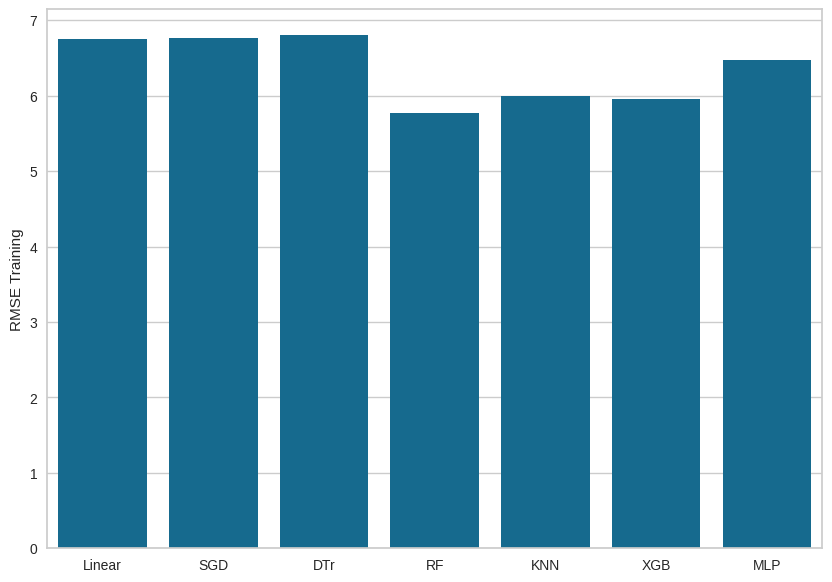

In [141]:
list_scores = [sc_linear,sc_sgd, sc_dtree, sc_rf, sc_knn, sc_xgb, sc_mlp_reg]
list_predictions = [pred_linreg_all, pred_sgd, pred_dtree, pred_rf, pred_knn, pred_xgb, pred_mlp_reg]
list_regressors = ['Linear','SGD','DTr','RF','KNN','XGB','MLP']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

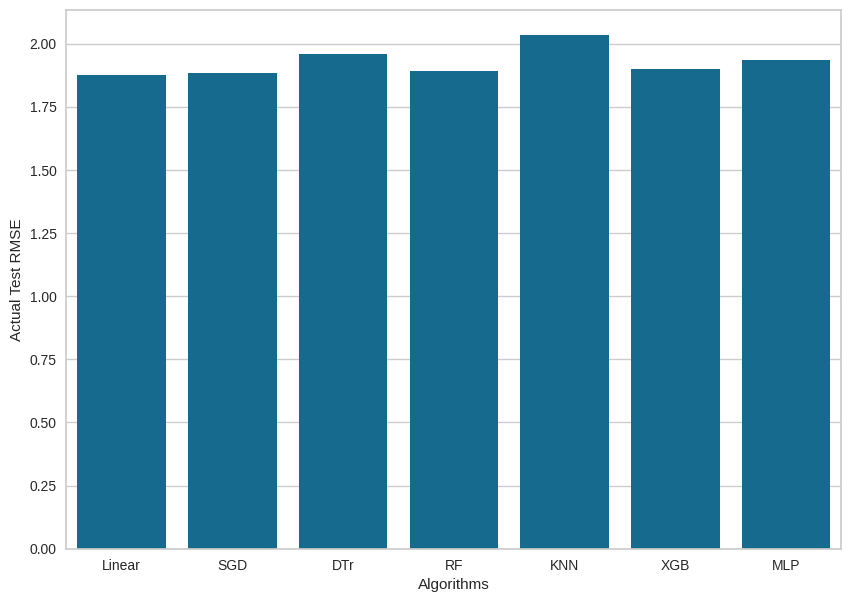

In [142]:
errors = []
for pred in list_predictions:
    errors.append(np.log(np.sqrt(mean_squared_error(y_test,pred))))

regressors = ['Linear','SGD','DTr','RF','KNN','XGB','MLP']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x = regressors, y = errors, ax=ax)
plt.ylabel('Actual Test RMSE')
plt.xlabel('Algorithms')
plt.show()

In [143]:
predictions = {'Linear': pred_linreg_all.ravel(),
               'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn.ravel(), 'XGB': pred_xgb, 'MLP':pred_mlp_reg }
df_predictions = pd.DataFrame(data=predictions)

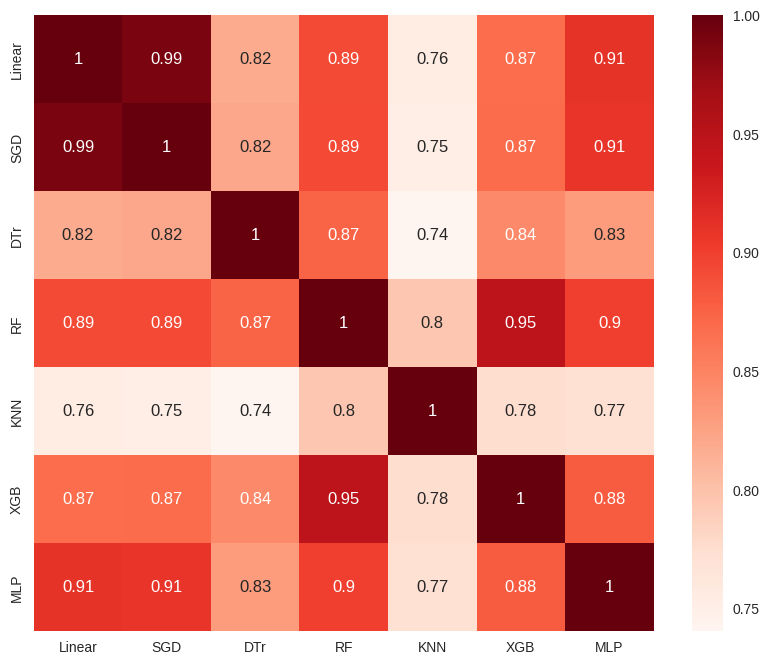

In [144]:
plt.figure(figsize=(10,8))
cor_pred = df_predictions.corr()
sns.heatmap(cor_pred, annot=True, cmap=plt.cm.Reds)
plt.show()

# Meta Model Approach

In [145]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html
#https://github.com/dataprofessor/python/blob/main/Stacking_Classifier.ipynb

estimators =[('lr', grid_linear),
    ('sdg', grid_sgd),
    ('dt', grid_dtree),
    ('rf', grid_rf),
    ('knn', grid_knn),
    ('xgb',grid_xgb),
    ('mlp', grid_mlp_reg)
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

In [146]:
# Train stacked model
stack_model.fit(x_train.values, y_train['rh100'].values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-25.224 total time=  19.9s
[CV 2/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-26.678 total time=  20.3s
[CV 3/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-33.305 total time=  19.9s
[CV 4/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-37.898 total time=  21.0s
[CV 5/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-43.471 total time=  19.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-32.052 total time=  15.1s
[CV 2/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-29.234 total time=  15.2s
[CV 3/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-38.653 total time=  15.2s
[CV 4/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-37.476 total time=  15.3s
[CV 5/5] END min_samples_split=3, n_estimators=150, random_state=5;, score=-44.854 total time=  15.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END min_samples_split=3, n_estimators=150, random_state=5;, sco

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

StackingRegressor(estimators=[('lr',
                               GridSearchCV(cv=5, estimator=LinearRegression(),
                                            param_grid={'copy_X': [True, False],
                                                        'fit_intercept': [True,
                                                                          False]},
                                            scoring='neg_mean_squared_error',
                                            verbose=1)),
                              ('sdg',
                               GridSearchCV(cv=5, estimator=SGDRegressor(),
                                            param_grid={'alpha': [1e-05],
                                                        'epsilon': [0.01],
                                                        'fit_intercept': [True],
                                                        'max_iter': [10000]},
                                            scoring='neg_mean_sq...
                                            scoring='neg_mean_squared_error')),
                              ('mlp',
                               GridSearchCV(cv=5, estimator=MLPRegressor(),
                                            param_grid={'activation': ['logistic'],
                                                        'alpha': [5e-05],
                                                        'hidden_layer_sizes': [(50,)],
                                                        'learning_rate_init': [0.001],
                                                        'random_state': [5],
                                                        'solver': ['lbfgs']},
                                            scoring='neg_mean_squared_error',
                                            verbose=True))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [ ]:
# fn = list(x_train.columns.values)

# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,12), dpi=800)
# tree.plot_tree(stack_model.estimators_[0],
#                feature_names = fn,
#                class_names=['rh100'],
#                filled = True);
# fig.savefig('stack_model_individualtree.png')

In [ ]:
# sorted_idx = stack_model.feature_importances_.argsort()
# plt.barh(stack_model.feature_importances_[sorted_idx])
# plt.xlabel("stack_model Feature Importance")

Shap viz

In [ ]:
explainer = shap.KernelExplainer(stack_model.predict, x_train.values)
shap_values = explainer.shap_values(x_train.values)
shap.summary_plot(shap_values, x_train.values, plot_type="bar")


  0%|          | 0/4000 [00:00<?, ?it/s]

In [67]:
# Make predictions
y_train_pred_stack = stack_model.predict(x_train)
y_test_pred_stack = stack_model.predict(x_test)

In [68]:
# Training set model performance
print("# Training set model performance")
print("MAE train on test",mean_absolute_error(y_train,y_train_pred_stack))
print("MSE train on test",mean_squared_error(y_train,y_train_pred_stack))
r2 = r2_score(y_train,y_train_pred_stack)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_train,y_train_pred_stack))))

# Test set model performance
print("# Test set model performance")
print("# Training set model performance")
print("MAE train on test",mean_absolute_error(y_test,y_test_pred_stack))
print("MSE train on test",mean_squared_error(y_test,y_test_pred_stack))
r2 = r2_score(y_test,y_test_pred_stack)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test,y_test_pred_stack))))


# Training set model performance
MAE train on test 2.1927428437849996
MSE train on test 8.836230023844392
R2 train on test 0.872674830527024
RMSE train on test 1.0894301588976762
# Test set model performance
# Training set model performance
MAE train on test 5.26209669424
MSE train on test 50.490502853987074
R2 train on test 0.39398733725808177
RMSE train on test 1.9608926281490486


<Axes: xlabel='y_train', ylabel='pred'>

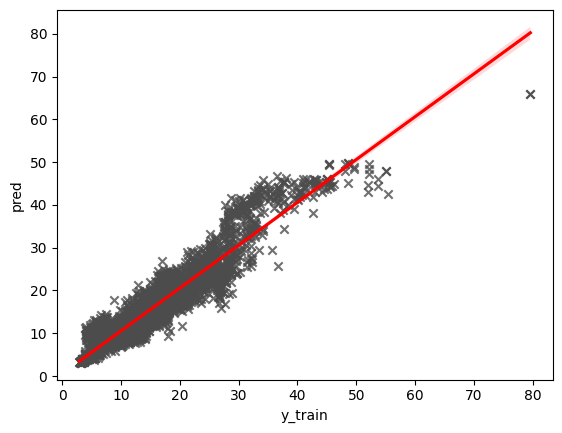

In [73]:
rf_train_plot_df = pd.DataFrame({'y_train':y_train['rh100'], 'pred':y_train_pred_stack})
# rf_test_plot_df.plot('y_test', 'pred', kind='scatter')

sns.regplot(data=rf_train_plot_df,x = 'y_train', y = 'pred',  ci=99, marker="x", color=".3", line_kws=dict(color="r"))

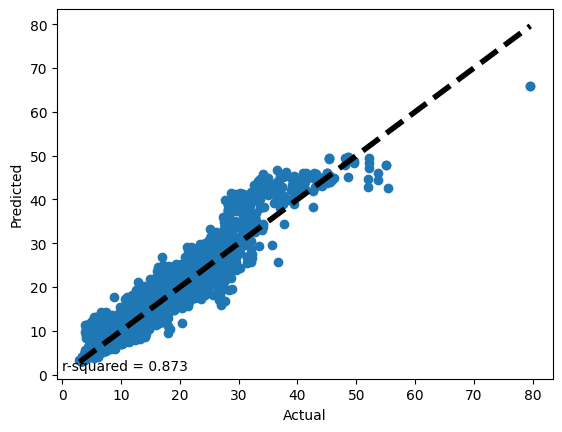

In [75]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_train_pred_stack)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
# #regression line

plt.annotate("r-squared = {:.3f}".format(r2_score(y_train, y_train_pred_stack)), (0, 1))
plt.show()

<Axes: xlabel='y_test', ylabel='pred'>

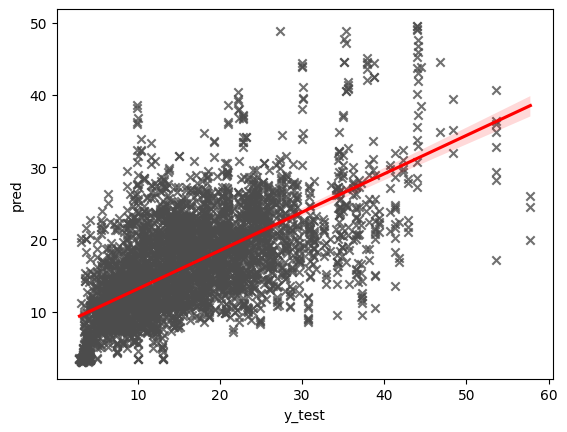

In [70]:
rf_test_plot_df = pd.DataFrame({'y_test':y_test['rh100'], 'pred':y_test_pred_stack})
# rf_test_plot_df.plot('y_test', 'pred', kind='scatter')

sns.regplot(data=rf_test_plot_df,x = 'y_test', y = 'pred',  ci=99, marker="x", color=".3", line_kws=dict(color="r"))

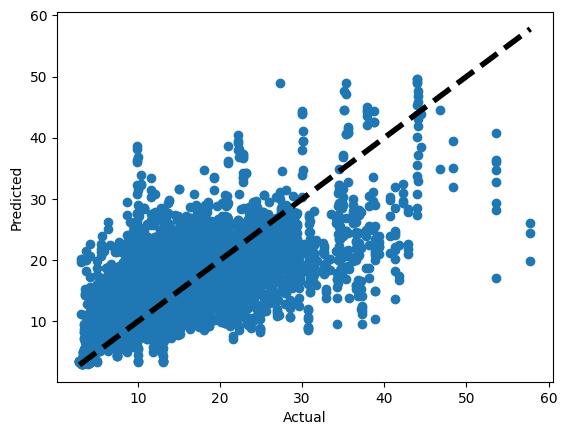

In [76]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred_stack)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
# #regression line

plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_test_pred_stack)), (0, 1))
plt.show()

Validation

In [79]:
y_val_pred_stack = stack_model.predict(x_validation)

In [80]:
# Test set model performance
print("# Test set model performance")
print("# Training set model performance")
print("MAE train on test",mean_absolute_error(y_validation,y_val_pred_stack))
print("MSE train on test",mean_squared_error(y_validation,y_val_pred_stack))
r2 = r2_score(y_validation,y_val_pred_stack)
print("R2 train on test", r2)
print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_validation,y_val_pred_stack))))


# Test set model performance
# Training set model performance
MAE train on test 5.235597518497499
MSE train on test 47.30471661912174
R2 train on test 0.2567110055388323
RMSE train on test 1.9283050038163176


<Axes: xlabel='y_val', ylabel='pred'>

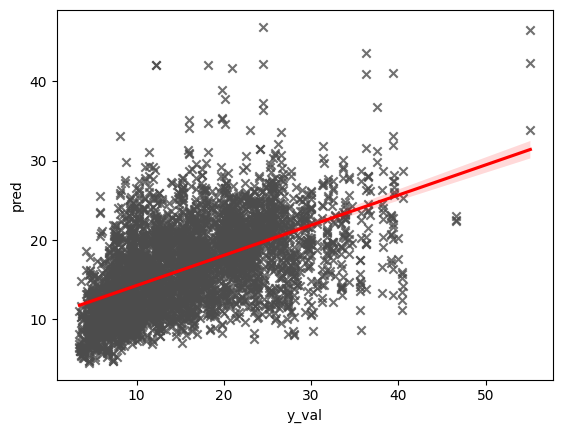

In [81]:
rf_test_plot_df = pd.DataFrame({'y_val':y_validation['rh100'], 'pred':y_val_pred_stack})
# rf_test_plot_df.plot('y_test', 'pred', kind='scatter')

sns.regplot(data=rf_test_plot_df,x = 'y_val', y = 'pred',  ci=99, marker="x", color=".3", line_kws=dict(color="r"))

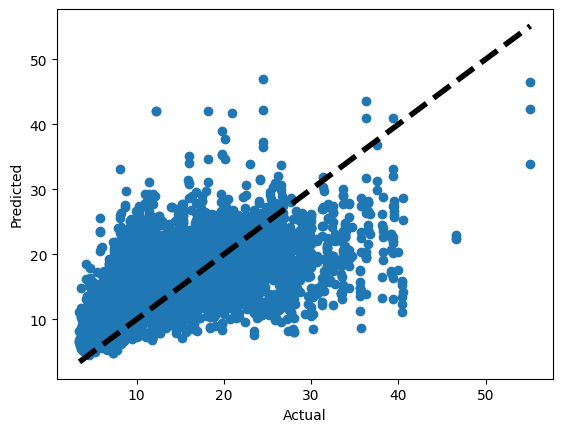

In [82]:
fig, ax = plt.subplots()
ax.scatter(y_validation, y_val_pred_stack)
ax.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
# #regression line

plt.annotate("r-squared = {:.3f}".format(r2_score(y_validation, y_val_pred_stack)), (0, 1))
plt.show()

In [34]:

# # Initialize base models
# rf = RandomForestRegressor(n_estimators=50, random_state=42)
# knn = KNeighborsRegressor(n_neighbors=5)
# lr = LinearRegression()

# # Fit base models on training data
# rf.fit(x_train, y_train['rh100'])
# knn.fit(x_train, y_train)
# lr.fit(x_train, y_train)

# # Generate base model predictions on training and validation data
# rf_pred_train = rf.predict(x_train)
# knn_pred_train = knn.predict(x_train)
# lr_pred_train = lr.predict(x_train)

# rf_pred_val = rf.predict(x_test)
# knn_pred_val = knn.predict(x_test)
# lr_pred_val = lr.predict(x_test)

test

In [35]:
# from sklearn.ensemble import RandomForestRegressor

In [36]:
# # Combine base model predictions into meta features
# meta_features_train = np.column_stack((rf_pred_train, knn_pred_train, lr_pred_train))
# meta_features_val = np.column_stack((rf_pred_val, knn_pred_val, lr_pred_val))

# # Initialize meta model
# ridge = Ridge(alpha=0.5)

In [ ]:
# # Fit meta model on meta features and training target variable
# ridge.fit(meta_features_train, y_train)

# # Generate meta model predictions on validation set
# meta_pred_val = ridge.predict(meta_features_val)

# from sklearn.metrics import mean_squared_error

# # Calculate MSE on validation set
# mse = mean_squared_error(y_test, meta_pred_val)
# print("MSE on validation set: {:.4f}".format(mse))


# print("MAE train on test",mean_absolute_error(y_test, meta_pred_val))

# print("MSE train on test",mean_squared_error(y_test, meta_pred_val))

# r2 = r2_score(y_test, meta_pred_val)
# print("R2 train on test", r2)

# print("RMSE train on test",np.log(np.sqrt(mean_squared_error(y_test, meta_pred_val))))

In [ ]:
# meta_pred_val

In [ ]:
# rf_test_plot_df = pd.DataFrame({'y_test':y_test['rh100'], 'pred':meta_pred_val})
# # rf_test_plot_df.plot('y_test', 'pred', kind='scatter')

# sns.regplot(data=rf_test_plot_df,x = 'y_test', y = 'meta_pred_val',  ci=99, marker="x", color=".3", line_kws=dict(color="r"))